In [1]:
import os
import pathlib
from glob import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime as dt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-12 09:23:17.450840: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 09:23:17.542853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 09:23:17.542908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 09:23:17.557122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 09:23:17.586351: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=1)
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]


    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # print(len(total_acc))
    # print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
        "dir_name/experiment_name/current_datetime/"

    Args:
        dir_name: target directory to store TensorBoard log files
        experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# Load data

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPU(s) found:")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(" -", gpu)
else:
    print("No GPU(s) found.")


GPU(s) found:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-12 09:23:18.502294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 09:23:18.568827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 09:23:18.568971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
train_dir = '/home/nripstein/code/train_test_split_0.4/train'
valid_dir = '/home/nripstein/code/train_test_split_0.4/test'
IMAGE_DIMENSIONS = (224, 224)

data_gen = ImageDataGenerator()  # don't use rescale=1./255 because EfficientNetBx doesn't want rescaled data

train_data = data_gen.flow_from_directory(directory=train_dir,
                                          target_size=IMAGE_DIMENSIONS,
                                          class_mode="binary",
                                          batch_size=32,
                                          seed=42,
                                          shuffle=True)

valid_data = data_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=IMAGE_DIMENSIONS,
                                          class_mode="binary",
                                          seed=42,
                                          shuffle=False)  # don't shuffle validation or test data so labels are ordered correctly when evaluation

Found 34940 images belonging to 2 classes.
Found 52412 images belonging to 2 classes.


# Design neural network

In [5]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # could try mode=HORIZONTAL_AND_VERTICAL
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(factor=0.1),
], name="data_augmentation_layer")

2024-01-12 09:23:19.059845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 09:23:19.060100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 09:23:19.060280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
INPUT_SHAPE = IMAGE_DIMENSIONS + (3,)

# create frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, drop_connect_rate=0.4) # default drop_connect_rate is 0.2, 0.4 increases regularization
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False)
base_model.trainable = False

# create inputs and outputs and layers between
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batch norm layers don't get updated. we want this even in fine tuning

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling2d")(x) # turn base model into feature vector
x = tf.keras.layers.Dropout(0.5, name="droupout_layer")(x) # droupout to reduce overfitting

outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# TEST VALID START

In [7]:
def test_load_images(image_dir):
    bad_files = []
    for subdir, dirs, files in os.walk(image_dir):
        for file in files:
            try:
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path)
                img.verify()  # Verify if it's an image
            except (IOError, SyntaxError):
                bad_files.append(img_path)  # Add the path of the bad file to the list
    return bad_files

# Example of how to use the function
bad_train_files = test_load_images(train_dir)
bad_valid_files = test_load_images(valid_dir)

print("Number of bad files in training set:", len(bad_train_files))
print("Bad files in training set:", bad_train_files)

print("Number of bad files in validation set:", len(bad_valid_files))
print("Bad files in validation set:", bad_valid_files)


Number of bad files in training set: 0
Bad files in training set: []
Number of bad files in validation set: 0
Bad files in validation set: []


# Train neural network using feature extraction

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPU(s) found:")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No GPU(s) found.")

tf.random.set_seed(42)

initial_epochs = 3

checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=False)

model_history = model.fit(train_data,
                          epochs=initial_epochs,
                          steps_per_epoch=len(train_data),
                          validation_data=valid_data,
                          validation_steps=int(len(valid_data)),
                          callbacks=[create_tensorboard_callback("training_logs",
                                                                 "efficientnetb0_0.4"),
                                     model_checkpoint])

GPU(s) found:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Saving TensorBoard log files to: training_logs/efficientnetb0_0.4/20240112-092329
Epoch 1/3


2024-01-12 09:23:32.486282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/1092 [..............................] - ETA: 1:05:22 - loss: 0.8071 - accuracy: 0.3438

2024-01-12 09:23:33.271356: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f94f1bd8700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 09:23:33.271373: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-12 09:23:33.276595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705069413.331992    8210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1092/1092 [==============================] - 260s 235ms/step - loss: 0.4077 - accuracy: 0.8185 - val_loss: 0.3048 - val_accuracy: 0.9081
Epoch 2/3
1092/1092 [==============================] - 249s 228ms/step - loss: 0.3216 - accuracy: 0.8649 - val_loss: 0.3142 - val_accuracy: 0.8771
Epoch 3/3
1092/1092 [==============================] - 247s 227ms/step - loss: 0.3037 - accuracy: 0.8717 - val_loss: 0.2526 - val_accuracy: 0.9190


In [9]:
model_initial_results = calculate_results(valid_data.labels, np.round(model.predict(valid_data)))
model_initial_results

1638/1638 [==============================] - 150s 91ms/step


{'accuracy': 0.9190070976112341,
 'precision': 0.9220470518550822,
 'recall': 0.9190070976112341,
 'f1': 0.9189813321369917}

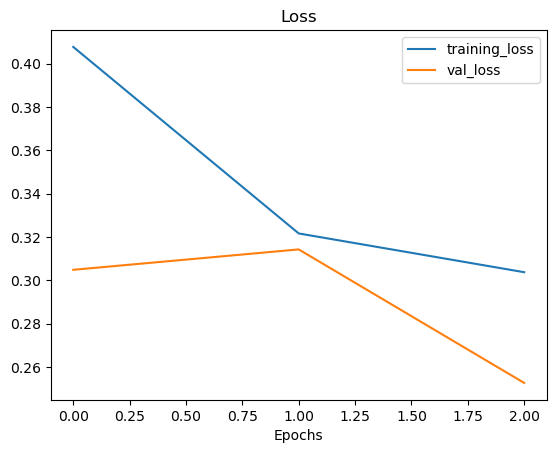

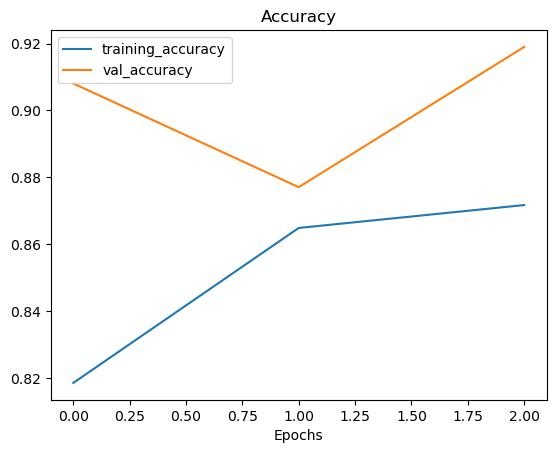

In [10]:
plot_loss_curves(model_history)

# Fine tuning

In [11]:
base_model.trainable = True

# allow training of last 5 layers of EfficientNet
for layer in base_model.layers[:-5]:
    layer.trainable = False


# recompile model whenever we make a change
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # lower learning rate for fine tuning because the unfrozen layers have already learned
              metrics=["accuracy"])

In [13]:
# fine tune for another 3 epochs
fine_tune_epochs = initial_epochs + 1

# refit model (same as without fine-tuning, but has more trainable layers)
model_fine_tune_history = model.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    steps_per_epoch=(len(train_data)),
                                    validation_data=valid_data,
                                    validation_steps=int(len(valid_data)),
                                    initial_epoch=initial_epochs,# model_history.epoch[-1] # start training from previous last epoch
                                    )

Epoch 4/4
1092/1092 [==============================] - 425s 386ms/step - loss: 0.1838 - accuracy: 0.9279 - val_loss: 0.1378 - val_accuracy: 0.9473


In [14]:
model_tuned_predicted_val_labels = np.round(model.predict(valid_data))
model_tuned_results = calculate_results(valid_data.labels, model_tuned_predicted_val_labels)
model_tuned_results

1638/1638 [==============================] - 152s 92ms/step


{'accuracy': 0.9473212241471419,
 'precision': 0.9502704269711589,
 'recall': 0.9473212241471419,
 'f1': 0.9473078933886534}

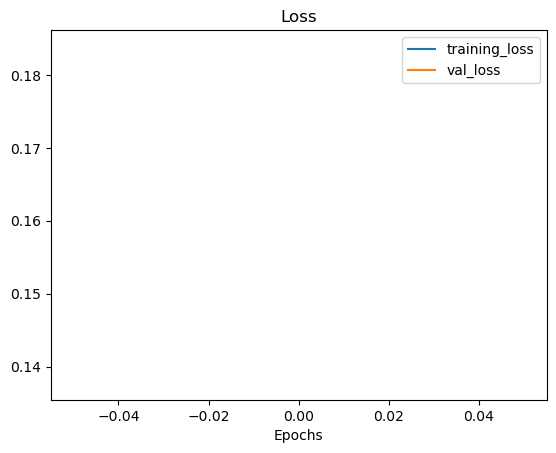

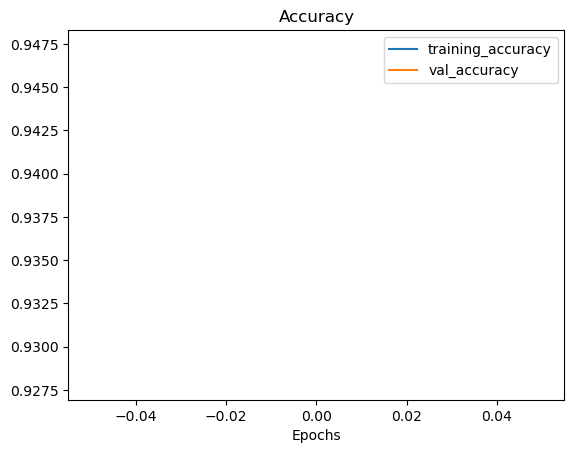

In [15]:
plot_loss_curves(model_fine_tune_history)

# Save model

In [13]:
folder_path = "saved_model_h5"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save TF Hub Sentence Encoder model to HDF5 format inside the folder
# model.save(os.path.join(folder_path, "sr_sv_nr_b0_0.4_3t_1f.h5"))
model.save('/home/nripstein/code/Undergrad-Thesis/models/sr_sv_nr_b0_0.4_3t_1f.h5')

/home/nripstein/miniconda3/envs/tf3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
